In [1]:
import pandas as pd
import numpy as np

In [2]:
MTURK_RES_DIR = "/Users/yiweiluo/mturk_tools/Submiterator/projectfiles/"
PILOTS = [0,1,2,3]
PILOT_DIRS = {pilot_no: "cc_stance_LIVE_pilot_{}/".format(pilot_no) for pilot_no in PILOTS}

Pilot 1: Changed target to "Climate change/global warming is a serious concern."

Pilot 2: Added time lag for button appearance.

Pilot 3: Added state Q, changed to GitHub site, new Likert q "Concerns about global warming are exaggerated".

In [3]:
import json
TRIAL_SENTS = {pilot_no: [] for pilot_no in PILOTS}
with open(MTURK_RES_DIR + PILOT_DIRS[0] + 'pilot_0_main_trials.jsonlist') as f:
    lines = f.readlines()
for ix in range(0,270,9):
    line_chunk = [l.strip() for l in lines[ix:ix+9]]
    line_chunk = "".join(line_chunk)
    if line_chunk[-1] == ',':
        line_chunk = line_chunk[:-1]
    TRIAL_SENTS[0].append(json.loads(line_chunk))
with open(MTURK_RES_DIR + PILOT_DIRS[1] + 'pilot_1_trials.jsonlist') as f:
    lines = f.readlines()
for ix in range(0,270,9):
    line_chunk = [l.strip() for l in lines[ix:ix+9]]
    line_chunk = "".join(line_chunk)
    if line_chunk[-1] == ',':
        line_chunk = line_chunk[:-1]
    TRIAL_SENTS[1].append(json.loads(line_chunk))
    TRIAL_SENTS[2].append(json.loads(line_chunk))
    TRIAL_SENTS[3].append(json.loads(line_chunk))

In [4]:
sent_id_to_sent = {pilot_no: {x['sent_id']:x['sentence'] for x in TRIAL_SENTS[pilot_no]}
                   for pilot_no in PILOTS}

In [5]:
SUBJECT_INFOS = {pilot_no: pd.read_csv(MTURK_RES_DIR+PILOT_DIRS[pilot_no]+\
                                       "cc_stance_pilot_{}-subject-info.csv".format(pilot_no))
                                      for pilot_no in PILOTS}
TRIAL_INFOS = {pilot_no: pd.read_csv(MTURK_RES_DIR+PILOT_DIRS[pilot_no]+\
                                    "cc_stance_pilot_{}-trials.csv".format(pilot_no))
              for pilot_no in PILOTS}
for pilot_no in PILOTS:
    TRIAL_INFOS[pilot_no]['sentence'] = [sent_id_to_sent[pilot_no][s_id] for s_id in 
                                        TRIAL_INFOS[pilot_no]['trial_sent_id']]

In [6]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [54]:
SUBJECT_INFOS[3]

,startDate,startTime,practiceEndTime,practiceTimeSpent,HitCorrect,HitFamiliar,age,gender,education,party,state,endTime,timeSpent,likert1,likert2,likert3,likert4,likert5,likert6,workerid
0,Tue Nov 05 2019 16:28:43 GMT-0500 (Eastern Standard Time),1572989323258,1572989839356,8.601633,0,1,25,male,graduated_college,republican,NY,1572989987590,11.072200,agree,neutral,strong_agree,neutral,strong_agree,agree,A3JLE2LJ5I17E2
1,Tue Nov 05 2019 16:36:09 GMT-0500 (Eastern Standard Time),1572989769343,1572989983520,3.569617,404,1,34,male,graduated_college,independent,FL,1572990378835,10.158200,strong_disagree,agree,strong_agree,neutral,neutral,strong_disagree,A38QGJJOZANQ4B
2,Tue Nov 05 2019 13:39:21 GMT-0800 (Pacific Standard Time),1572989961286,1572990197203,3.931950,0,404,60,female,graduated_college,republican,WA,1572990707132,12.430767,disagree,neutral,strong_agree,disagree,disagree,strong_agree,A2PXJTMWGUE5DC


In [9]:
TRIAL_INFOS[3]

,RT,trial_sent_id,workerid,trial_number,condition,option_chosen,sentence
0,3412,t12,0,1,true,disagrees,Rather than the earlier prediction of warmer a...
1,1927,t17,0,2,true,agrees,Global warming is not a crisis.
2,4590,t15,0,3,true,disagrees,About five years ago the environmental groups ...
3,2317,t2,0,4,true,neutral,The growing deluge of greenhouse gas emissions...
4,2362,t18,0,5,true,disagrees,Climate can change from both natural and anthr...
5,3629,t23,0,6,true,agrees,"On the upside, weaning ourselves off of fossil..."
6,3299,s3,0,7,screen,agrees,Global warming is happening and it will be dan...
7,2422,t10,0,8,true,disagrees,Natural gas pipelines are crucial to national ...
8,3494,t4,0,9,true,neutral,There's no longer any serious doubt that clima...
9,3142,t5,0,10,true,disagrees,Measures such as conservation won't cost much ...


In [10]:
trials_per_worker = {pilot_no: TRIAL_INFOS[pilot_no].groupby('workerid') 
                    for pilot_no in PILOTS}

In [36]:
trials_per_worker[3].get_group(0)

,RT,trial_sent_id,trial_number,condition,option_chosen,sentence
0,3412,t12,1,true,disagrees,"Rather than the earlier prediction of warmer and drier weather here, conditions would get cooler and wetter."
1,1927,t17,2,true,agrees,Global warming is not a crisis.
2,4590,t15,3,true,disagrees,About five years ago the environmental groups were supportive of natural gas technology as a cleaner alternative.
3,2317,t2,4,true,neutral,The growing deluge of greenhouse gas emissions continue.
4,2362,t18,5,true,disagrees,Climate can change from both natural and anthropogenic causes.
5,3629,t23,6,true,agrees,"On the upside, weaning ourselves off of fossil fuels will likely happen at some point, just not tomorrow."
6,3299,s3,7,screen,agrees,Global warming is happening and it will be dangerous to human health and welfare.
7,2422,t10,8,true,disagrees,Natural gas pipelines are crucial to national security.
8,3494,t4,9,true,neutral,"There's no longer any serious doubt that climate change is real, accelerating, and caused by human activities."
9,3142,t5,10,true,disagrees,Measures such as conservation won't cost much and will buy insurance against global warming.


In [11]:
for pilot_no in PILOTS:
    print('============ Pilot #{} ============'.format(pilot_no))
    print('Mean time spent:',SUBJECT_INFOS[pilot_no]['timeSpent'].mean())
    print('Max time spent:',SUBJECT_INFOS[pilot_no]['timeSpent'].max())
    print('Min time spent:',SUBJECT_INFOS[pilot_no]['timeSpent'].min())
    print('\n')

============ Pilot #0 ============
Mean time spent: 10.652593333333334
Max time spent: 15.923516666666664
Min time spent: 5.732383333333333


============ Pilot #1 ============
Mean time spent: 8.3904
Max time spent: 10.110816666666668
Min time spent: 6.8712333333333335


============ Pilot #2 ============
Mean time spent: 14.331366666666668
Max time spent: 19.788016666666667
Min time spent: 11.43975


============ Pilot #3 ============
Mean time spent: 11.220388888888891
Max time spent: 12.430766666666667
Min time spent: 10.1582




Distribution of reading times per question:

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
RT_dists = {}
for pilot_no in PILOTS:
    question_groups = TRIAL_INFOS[pilot_no].groupby('trial_sent_id')
    df = pd.DataFrame(columns=['sent_id','sentence','mean RT (seconds)','max RT','min RT'])
    for sent_id in question_groups.first().index:
        df = df.append({'sent_id':sent_id,
                  'sentence':question_groups.get_group(sent_id)['sentence'].iloc[0],
                  'mean RT (seconds)':question_groups.get_group(sent_id)['RT'].mean()/1000.,
                  'max RT':question_groups.get_group(sent_id)['RT'].max()/1000.,
                  'min RT':question_groups.get_group(sent_id)['RT'].min()/1000.},
                 ignore_index=True)
    df = df.sort_values('mean RT (seconds)',ascending=False)
    RT_dists[pilot_no] = df

In [76]:
RT_dists[0]

,sent_id,sentence,mean RT (seconds),max RT,min RT
5,t0,The term global warming is associated with gre...,45.9706,187.879,7.263
10,t13,It must decide quickly on how to comply with p...,40.1268,167.009,5.071
1,s1,Alarming levels of sea level rise are predicte...,17.0126,45.384,4.455
29,t9,That may be the only meaningful alternative to...,16.4878,31.346,2.925
23,t3,Poorer nations adapt to the impacts of global ...,16.3384,43.071,3.348
11,t14,Environmental Protection Agency regulations to...,12.3446,17.574,6.709
13,t16,A transition to cleaner fuels will happen even...,12.3092,22.362,4.741
28,t8,The forecast was based on an expected change i...,10.0344,17.399,6.327
25,t5,Measures such as conservation won't cost much ...,9.5244,14.603,6.441
9,t12,Rather than the earlier prediction of warmer a...,9.0180,15.756,5.367


In [64]:
RT_dists[1]

,sent_id,sentence,mean RT (seconds),max RT,min RT
5,t0,The term global warming is associated with gre...,45.113000,113.590,10.079
13,t16,A transition to cleaner fuels will happen even...,17.668667,27.582,7.919
29,t9,That may be the only meaningful alternative to...,15.749667,17.842,11.814
28,t8,The forecast was based on an expected change i...,13.640667,21.045,7.663
23,t3,Poorer nations adapt to the impacts of global ...,10.528000,18.413,3.414
27,t7,Even if the countries followed today's commitm...,10.180333,16.231,4.760
11,t14,Environmental Protection Agency regulations to...,10.018667,12.933,5.716
12,t15,About five years ago the environmental groups ...,9.440667,15.456,3.733
21,t23,"On the upside, weaning ourselves off of fossil...",9.271667,11.797,5.166
10,t13,It must decide quickly on how to comply with p...,8.520667,12.960,3.796


In [14]:
RT_dists[3]

,sent_id,sentence,mean RT (seconds),max RT,min RT
10,t13,It must decide quickly on how to comply with p...,22.225000,38.660,3.487
11,t14,Environmental Protection Agency regulations to...,21.024667,27.988,7.125
9,t12,Rather than the earlier prediction of warmer a...,20.089000,49.023,3.412
7,t10,Natural gas pipelines are crucial to national ...,16.185667,38.247,2.422
29,t9,That may be the only meaningful alternative to...,14.472000,23.864,3.976
23,t3,Poorer nations adapt to the impacts of global ...,13.222000,25.407,2.820
5,t0,The term global warming is associated with gre...,11.124667,15.144,5.700
22,t24,No single episode can either prove or disprove...,11.048667,19.663,2.587
2,s2,"Over the past several years, the United States...",10.388333,14.903,4.822
25,t5,Measures such as conservation won't cost much ...,10.276333,17.688,3.142


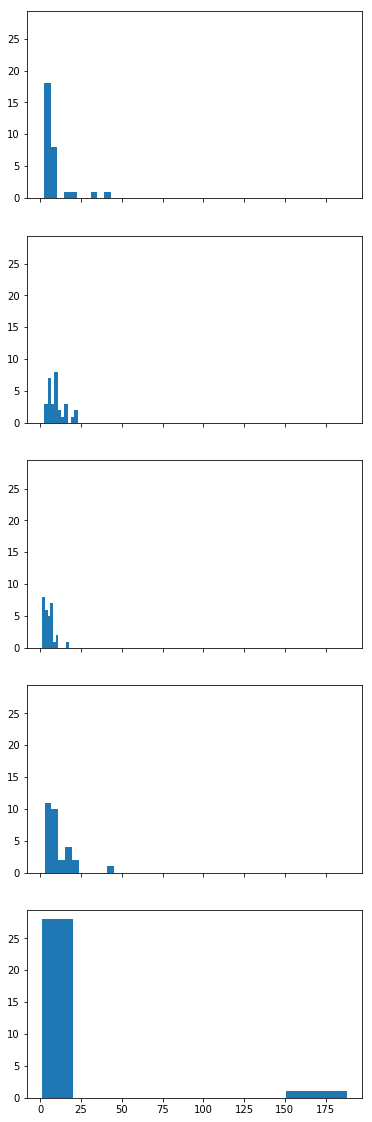

In [67]:
# Pilot 0
fig,ax_list = plt.subplots(5,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2,3,4]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[0].get_group(w_id)['RT']/1000.)

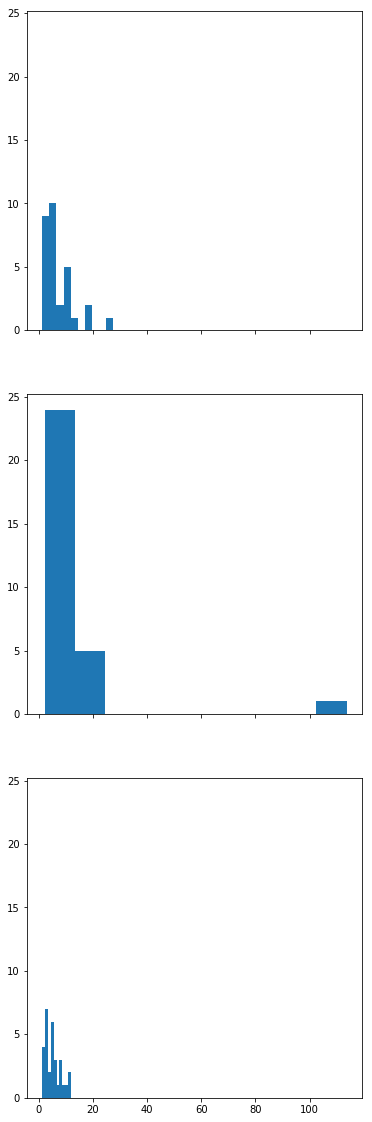

In [68]:
# Pilot 1
fig,ax_list = plt.subplots(3,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[1].get_group(w_id)['RT']/1000.)

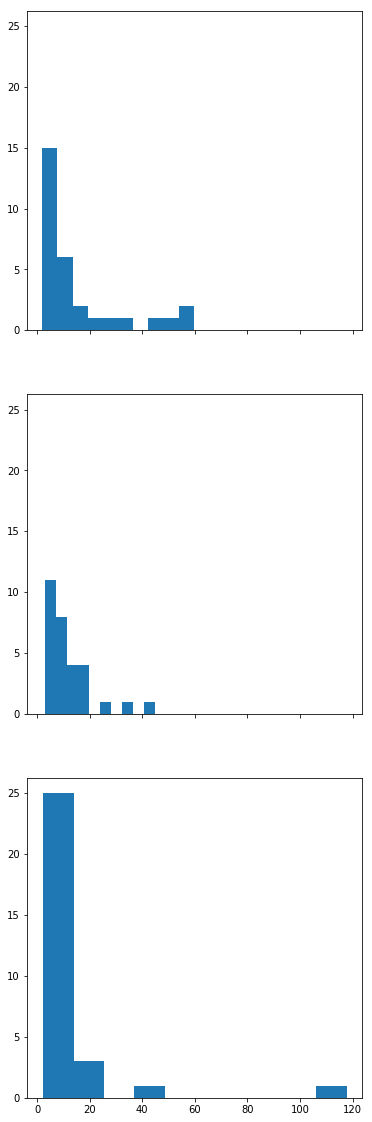

In [69]:
# Pilot 2
fig,ax_list = plt.subplots(3,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[2].get_group(w_id)['RT']/1000.)

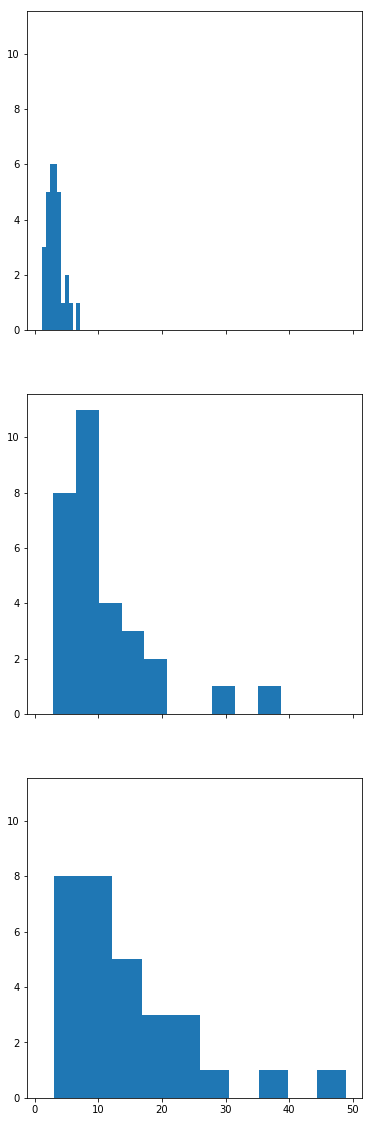

In [15]:
# Pilot 3
fig,ax_list = plt.subplots(3,1,figsize=(6,20),sharey=True,sharex=True)
for w_id in [0,1,2]:#worker_ids:
    ax_list[w_id].hist(trials_per_worker[3].get_group(w_id)['RT']/1000.)

Organize party and likert responses:

In [16]:
likert_qs_0 = ["Global average temperatures have been increasing over the past century.",
            "Humans are the primary cause of this global warming.",
            "Global warming is a natural process.",
            "Urgent government action is required to address the problem of global warming.",
            "We should continue to rely on fossil fuels as our primary source of energy.",
            "I trust the ability of news media to provide unbiased coverage of science."]
likert_qs_1 = ["Global average temperatures have been increasing over the past century.",
              "Natural temperature fluctuations account for the majority of this global warming.",
              "Humans are the primary cause of this global warming.",
              "Urgent government action is required to address the problem of global warming.",
              "We should continue to rely on fossil fuels as our primary source of energy.",
              "I trust the ability of news media to provide unbiased coverage of science."]
likert_qs_2 = ["I trust the ability of news media to provide unbiased coverage of science.",
              "Global average temperatures have been increasing over the past century.",
              "Natural temperature fluctuations account for the majority of this global warming.",
              "Humans are the primary cause of this global warming.",
              "Urgent government action is required to address the problem of global warming.",
              "We should continue to rely on fossil fuels as our primary source of energy."]
likert_qs_3 = ["I trust the ability of news media to provide unbiased coverage of science.",
              "Global average temperatures have been increasing over the past century.",
              "Concerns about global warming are exaggerated.",
              "Humans are the primary cause of global warming.",
              "Urgent government action is required to address the problem of global warming.",
              "We should continue to rely on fossil fuels as our primary source of energy."]

In [17]:
likert_df_0 = SUBJECT_INFOS[0][['likert{}'.format(ix) for ix in range(1,7)]].T
likert_df_1 = SUBJECT_INFOS[1][['likert{}'.format(ix) for ix in range(1,7)]].T
likert_df_2 = SUBJECT_INFOS[2][['likert{}'.format(ix) for ix in range(1,7)]].T
likert_df_3 = SUBJECT_INFOS[3][['likert{}'.format(ix) for ix in range(1,7)]].T

In [18]:
likert_df_0['statement'] = likert_qs_0
likert_df_1['statement'] = likert_qs_1
likert_df_2['statement'] = likert_qs_2
likert_df_3['statement'] = likert_qs_3

In [73]:
likert_df_0.set_index('statement')

,0,1,2,3,4
statement,,,,,
Global average temperatures have been increasing over the past century.,strong_agree,agree,strong_agree,agree,strong_agree
Humans are the primary cause of this global warming.,agree,strong_agree,strong_agree,strong_agree,strong_agree
Global warming is a natural process.,disagree,strong_agree,neutral,strong_agree,agree
Urgent government action is required to address the problem of global warming.,strong_agree,strong_agree,strong_agree,strong_agree,strong_agree
We should continue to rely on fossil fuels as our primary source of energy.,strong_disagree,neutral,disagree,disagree,agree
I trust the ability of news media to provide unbiased coverage of science.,strong_disagree,strong_disagree,neutral,disagree,strong_agree


In [250]:
subject_info['party']

0    republican 
1    republican 
2    democrat   
3    democrat   
4    independent
Name: party, dtype: object

In [74]:
likert_df_1.set_index('statement')

,0,1,2
statement,,,
Global average temperatures have been increasing over the past century.,strong_agree,strong_agree,strong_agree
Natural temperature fluctuations account for the majority of this global warming.,disagree,neutral,neutral
Humans are the primary cause of this global warming.,strong_disagree,strong_agree,strong_agree
Urgent government action is required to address the problem of global warming.,strong_agree,strong_agree,strong_agree
We should continue to rely on fossil fuels as our primary source of energy.,disagree,neutral,disagree
I trust the ability of news media to provide unbiased coverage of science.,agree,strong_agree,disagree


In [282]:
subject_info_1['party']

0    republican 
1    independent
2    democrat   
Name: party, dtype: object

In [75]:
likert_df_2.set_index('statement')

,0,1,2
statement,,,
I trust the ability of news media to provide unbiased coverage of science.,disagree,strong_disagree,neutral
Global average temperatures have been increasing over the past century.,strong_agree,strong_disagree,agree
Natural temperature fluctuations account for the majority of this global warming.,strong_agree,strong_agree,strong_agree
Humans are the primary cause of this global warming.,neutral,strong_disagree,neutral
Urgent government action is required to address the problem of global warming.,neutral,strong_disagree,neutral
We should continue to rely on fossil fuels as our primary source of energy.,neutral,neutral,agree


In [396]:
subject_info_2['party']

0    independent
1    independent
2    republican 
Name: party, dtype: object

In [19]:
likert_df_3.set_index('statement')

,0,1,2
statement,,,
I trust the ability of news media to provide unbiased coverage of science.,agree,strong_disagree,disagree
Global average temperatures have been increasing over the past century.,neutral,agree,neutral
Concerns about global warming are exaggerated.,strong_agree,strong_agree,strong_agree
Humans are the primary cause of global warming.,neutral,neutral,disagree
Urgent government action is required to address the problem of global warming.,strong_agree,neutral,disagree
We should continue to rely on fossil fuels as our primary source of energy.,agree,strong_disagree,strong_agree


In [20]:
SUBJECT_INFOS[3]['party']

0     republican
1    independent
2     republican
Name: party, dtype: object

In [ ]:
# statement 3 "natural process" is confusing?
# Move to first statement?
# "Natural temperature fluctuations account for observed extreme weather events and increasing temperature"

# 0. Basic summary stats

In [ ]:
worker_annotations = {}
for pilot_no in PILOTS:
    labels_per_worker = {}
    for w_id in trials_per_worker[pilot_no].first().index:
        worker_labels = trials_per_worker[pilot_no].get_group(w_id).sort_values(by='trial_sent_id')
        worker_labels = worker_labels.set_index('trial_sent_id')
        worker_labels = worker_labels.drop(["trial_number","RT","condition","sentence"],axis=1)
        #print(worker_labels)
        worker_labels.columns = ['worker_{}'.format(w_id)]
        labels_per_worker[w_id] = worker_labels
    worker_annotations[pilot_no] = labels_per_worker

In [ ]:
all_worker_labels_0 = pd.concat([worker_annotations[0][0], worker_annotations[0][1], worker_annotations[0][2], 
                               worker_annotations[0][3], worker_annotations[0][4]], axis=1)
all_worker_labels_1 = pd.concat([worker_annotations[1][0], worker_annotations[1][1], 
                                 worker_annotations[1][2]], axis=1)
all_worker_labels_2 = pd.concat([worker_annotations[2][0], worker_annotations[2][1], 
                                 worker_annotations[2][2]], axis=1)
all_worker_labels_3 = pd.concat([worker_annotations[3][0], worker_annotations[3][1], 
                                 worker_annotations[3][2]], axis=1)

In [ ]:
sent_id_to_sent_0 = {x['sent_id']:x['sentence'] for x in TRIAL_SENTS[0]}
sent_id_to_sent_1 = {x['sent_id']:x['sentence'] for x in TRIAL_SENTS[1]}

In [ ]:
all_worker_labels_0['sentence'] = [sent_id_to_sent_0[s_id] for s_id in 
                                  all_worker_labels_0.index]
all_worker_labels_1['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_1.index]
all_worker_labels_2['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_2.index]
all_worker_labels_3['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_3.index]

In [ ]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS = all_worker_labels_1.iloc[5:].drop(['sentence'],axis=1)
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_3'] = all_worker_labels_2.iloc[5:].drop(['sentence'],axis=1)['worker_0']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_4'] = all_worker_labels_2.iloc[5:].drop(['sentence'],axis=1)['worker_1']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_5'] = all_worker_labels_2.iloc[5:].drop(['sentence'],axis=1)['worker_2']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_6'] = all_worker_labels_3.iloc[5:].drop(['sentence'],axis=1)['worker_0']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_7'] = all_worker_labels_3.iloc[5:].drop(['sentence'],axis=1)['worker_1']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_8'] = all_worker_labels_3.iloc[5:].drop(['sentence'],axis=1)['worker_2']
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['sentence'] = [sent_id_to_sent_1[s_id] for s_id in 
                                  all_worker_labels_3.index[5:]]

In [ ]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['av_rating'] = [np.average(
    [label2int[COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_{}'.format(w_id)].loc[sent_id]]
     for w_id in range(0,9)]) for sent_id in COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.index]

In [111]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS

,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,worker_8,sentence,av_rating
trial_sent_id,,,,,,,,,,,
t0,neutral,neutral,neutral,neutral,agrees,neutral,neutral,agrees,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change.",0.222222
t1,agrees,agrees,agrees,agrees,agrees,agrees,disagrees,agrees,agrees,The polar bear is being driven extinct by global warming.,0.777778
t10,disagrees,neutral,neutral,neutral,neutral,disagrees,disagrees,agrees,disagrees,Natural gas pipelines are crucial to national security.,-0.333333
t11,neutral,agrees,neutral,neutral,neutral,neutral,disagrees,agrees,disagrees,We cannot act until poor countries act.,0.000000
t12,disagrees,neutral,disagrees,neutral,neutral,neutral,disagrees,neutral,disagrees,"Rather than the earlier prediction of warmer and drier weather here, conditions would get cooler and wetter.",-0.444444
t13,neutral,neutral,neutral,neutral,neutral,neutral,disagrees,agrees,neutral,It must decide quickly on how to comply with proposed Environmental Protection Agency rules limiting carbon pollution.,0.000000
t14,disagrees,disagrees,neutral,neutral,neutral,neutral,disagrees,agrees,neutral,"Environmental Protection Agency regulations to curb mercury and other pollutants will force its utilities to close coal-fired plants, driving up customer bills and putting the grid's reliability at risk.",-0.222222
t15,disagrees,neutral,neutral,neutral,disagrees,disagrees,disagrees,agrees,neutral,About five years ago the environmental groups were supportive of natural gas technology as a cleaner alternative.,-0.333333
t16,disagrees,disagrees,neutral,neutral,neutral,neutral,disagrees,neutral,disagrees,"A transition to cleaner fuels will happen eventually based on natural trends in energy markets, and that forcing a change too rapidly would do more harm than good.",-0.444444


Plot distribution of ratings:

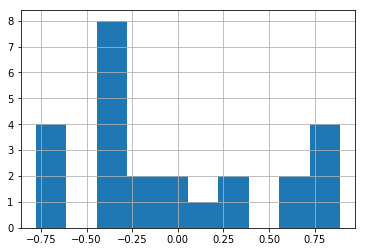

In [113]:
COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['av_rating'].hist()

Examine individual worker responses:

In [ ]:
pd.set_option('display.max_colwidth', -1)
#all_worker_labels_0

# 1. Fleiss's kappa for 2+ annotators

In [7]:
trial_info.columns

Index(['trial_number', 'RT', 'condition', 'workerid', 'trial_sent_id',
       'option_chosen'],
      dtype='object')

Break trials into chunks for each annotator:

In [251]:
trials_per_worker = trial_info.groupby('workerid')

In [252]:
trials_per_worker.first()

,trial_sent_id,RT,trial_number,condition,option_chosen
workerid,,,,,
0,t9,31346,1,true,neutral
1,s2,18869,1,screen,neutral
2,t14,17574,1,true,agrees
3,t19,11048,1,true,disagrees
4,t12,6544,1,true,neutral


In [258]:
worker_ids = list(trials_per_worker.first().index)

Step 1: Calculate how many assignments went (proportionally) to each category $(P_c)$.

$$P_c=\frac{1}{Aa}\sum_{i=1}^{A}a_{ic},$$

$A =$ number of annotators,
$a =$ number of annotations each annotator created,
$a_{ic} =$ number of annotations in category $c$ for annotator $i$ 

In [254]:
A = 5
a = 30

In [255]:
P_agree = 1./(A*a)*(np.sum([np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'agrees')
                           for w_id in worker_ids]))
P_disagree = 1./(A*a)*(np.sum([np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'disagrees')
                           for w_id in worker_ids]))
P_neutral = 1./(A*a)*(np.sum([np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'neutral')
                           for w_id in worker_ids]))

In [256]:
P_neutral

0.5133333333333334

Step 2: Calculate each annotator's agreement with other annotators, compared to all possible agreement values ($P_i$):

$$P_i = \frac{(\sum_{c=1}^ka_{ic}^2)-a}{a(a-1)},$$

$k =$ number of categories.

In [257]:
k = 3

In [259]:
P_annotators = {}
for w_id in worker_ids:
    P_annotators[w_id] = (np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'agrees')**2+\
    np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'disagrees')**2+\
    np.sum(trials_per_worker.get_group(w_id)['option_chosen'] == 'neutral')**2-a)/(a*(a-1.))

In [260]:
P_annotators

{0: 0.45057471264367815,
 1: 0.3195402298850575,
 2: 0.37471264367816093,
 3: 0.4850574712643678,
 4: 0.3724137931034483}

Step 3: Calculate $\bar{P}$, the average of ```P_annotators```:

In [261]:
P_av = np.mean(list(P_annotators.values()))

In [262]:
P_av

0.4004597701149425

Step 4: Calculate $\bar{P_e}$, the average of the expected agreement:

In [263]:
P_e = np.sum(P_agree**2 + P_disagree**2 + P_neutral**2)

In [264]:
P_e

0.38693333333333346

Step 5: Calculate Fleiss's kappa:

$$K = \frac{\bar{P}-\bar{P_e}}{1-\bar{P_e}}$$

In [265]:
kappa = (P_av-P_e)/(1.-P_e)

In [266]:
kappa

0.0220635658682183

"Slight agreement" within the range 0.01 - 0.20.

# 2. Correlation

Fleiss's kappa only measures agreement over category totals. Looking at correlation also gives us a p-value.

In [34]:
pd.set_option('display.max_colwidth', -1)
all_worker_labels_0

,worker_0,worker_1,worker_2,worker_3,worker_4,sentence
trial_sent_id,,,,,,
s0,disagrees,disagrees,disagrees,disagrees,disagrees,Global warming is a hoax.
s1,neutral,neutral,neutral,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,neutral,neutral,neutral,neutral,neutral,The current president of the US is a republican.
s3,agrees,agrees,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,neutral,neutral,neutral,neutral,neutral,Some dogs are cute.
t0,neutral,agrees,neutral,neutral,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,agrees,agrees,agrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,neutral,agrees,neutral,neutral,neutral,Natural gas pipelines are crucial to national security.
t11,neutral,agrees,neutral,neutral,neutral,We cannot act until poor countries act.


In [405]:
all_worker_labels_1

,worker_0,worker_1,worker_2,sentence
trial_sent_id,,,,
s0,disagrees,disagrees,disagrees,Global warming is a hoax.
s1,agrees,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,neutral,neutral,neutral,"Over the past several years, the United States has seen an increase in business growth that has counteracted the lingering effects of the recession."
s3,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,neutral,neutral,neutral,Some icebergs are are cute.
t0,neutral,neutral,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,agrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,disagrees,neutral,neutral,Natural gas pipelines are crucial to national security.
t11,neutral,agrees,neutral,We cannot act until poor countries act.


In [408]:
all_worker_labels_2

,worker_0,worker_1,worker_2,sentence
trial_sent_id,,,,
s0,disagrees,disagrees,disagrees,Global warming is a hoax.
s1,neutral,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,neutral,neutral,neutral,"Over the past several years, the United States has seen an increase in business growth that has counteracted the lingering effects of the recession."
s3,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,neutral,neutral,neutral,Some icebergs are are cute.
t0,neutral,agrees,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,agrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,neutral,neutral,disagrees,Natural gas pipelines are crucial to national security.
t11,neutral,neutral,neutral,We cannot act until poor countries act.


In [35]:
all_worker_labels_3

,worker_0,worker_1,worker_2,sentence
trial_sent_id,,,,
s0,neutral,disagrees,disagrees,Global warming is a hoax.
s1,disagrees,agrees,agrees,Alarming levels of sea level rise are predicted to threaten Florida over the next decades.
s2,disagrees,disagrees,neutral,"Over the past several years, the United States has seen an increase in business growth that has counteracted the lingering effects of the recession."
s3,agrees,agrees,agrees,Global warming is happening and it will be dangerous to human health and welfare.
s4,agrees,agrees,neutral,Some icebergs are are cute.
t0,neutral,agrees,neutral,"The term global warming is associated with greater public understanding, emotional engagement, and support for personal and national action than the term climate change."
t1,disagrees,agrees,agrees,The polar bear is being driven extinct by global warming.
t10,disagrees,agrees,disagrees,Natural gas pipelines are crucial to national security.
t11,disagrees,agrees,disagrees,We cannot act until poor countries act.


Step 1: Make binarized matrices for each annotator.

In [74]:
def convert_int(l):
    return int(l)

In [305]:
worker_matrices_0 = {}
worker_matrices_1 = {}

In [306]:
for w_id in worker_ids:
    label_matrix_w = pd.DataFrame.from_dict({'trial_sent_id':all_worker_labels_0.index,
                                        'agrees':list((all_worker_labels_0['worker_{}'.format(w_id)] == 'agrees').apply(convert_int)),
                                        'disagrees':list((all_worker_labels_0['worker_{}'.format(w_id)] == 'disagrees').apply(convert_int)),
                                        'neutral':list((all_worker_labels_0['worker_{}'.format(w_id)] == 'neutral').apply(convert_int))})
    label_matrix_w = label_matrix_w.set_index('trial_sent_id')
    worker_matrices_0[w_id] = label_matrix_w
for w_id in [0,1,2]:
    label_matrix_w = pd.DataFrame.from_dict({'trial_sent_id':all_worker_labels_1.index,
                                        'agrees':list((all_worker_labels_1['worker_{}'.format(w_id)] == 'agrees').apply(convert_int)),
                                        'disagrees':list((all_worker_labels_1['worker_{}'.format(w_id)] == 'disagrees').apply(convert_int)),
                                        'neutral':list((all_worker_labels_1['worker_{}'.format(w_id)] == 'neutral').apply(convert_int))})
    label_matrix_w = label_matrix_w.set_index('trial_sent_id')
    worker_matrices_1[w_id] = label_matrix_w

In [90]:
worker_matrices_0[3]

,agrees,disagrees,neutral
trial_sent_id,,,
s0,0,1,0
s1,1,0,0
s2,0,0,1
s3,1,0,0
s4,0,0,1
t0,0,0,1
t1,1,0,0
t10,0,0,1
t11,0,0,1


Step 2: Calculate spearman correlation coefficients for each worker's matrix with the other worker matrices:

In [91]:
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [ ]:
# Apply Wilcoxon signed rank test to test significance of each dimension
p_vals = np.apply_along_axis(wilcoxon, 0, corr_per_rater)[1]

In [ ]:
# Apply Bonferroni correction
reject, corr_pvals, _, newalpha = multipletests(
     p_vals, alpha=0.05, method="bonferroni") 

# 3. Krippendorff's alpha

In [46]:
from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None


def nominal_metric(a, b):
    return a != b


def interval_metric(a, b):
    return (a-b)**2


def ratio_metric(a, b):
    return ((a-b)/(a+b))**2


def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.


if __name__ == '__main__': 
    print("Example from http://en.wikipedia.org/wiki/Krippendorff's_Alpha")

    data = (
        "*    *    *    *    *    3    4    1    2    1    1    3    3    *    3", # coder A
        "1    *    2    1    3    3    4    3    *    *    *    *    *    *    *", # coder B
        "*    *    2    1    3    4    4    *    2    1    1    3    3    *    4", # coder C
    )

    missing = '*' # indicator for missing values
    array = [d.split() for d in data]  # convert to 2D list of string items
    
    print("nominal metric: %.3f" % krippendorff_alpha(array, nominal_metric, missing_items=missing))
    print("interval metric: %.3f" % krippendorff_alpha(array, interval_metric, missing_items=missing))

Example from http://en.wikipedia.org/wiki/Krippendorff's_Alpha
nominal metric: 0.691
interval metric: 0.811


In [48]:
label2int = {'agrees':1,'neutral':0,'disagrees':-1}

## Pilot 0

In [273]:
data_per_coder = []
for w_id in worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels.index if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [274]:
# Agreement for screen questions
krippendorff_alpha(data_per_coder)

0.8783783783783784

In [272]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.5345920745920746

In [275]:
# Pairwise agreements for full questions
for worker_id_a in [0,1,2,3]:
    for worker_id_b in range(worker_id_a+1,5):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(subject_info.iloc[worker_id_a]['party'],
                                                               subject_info.iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.5856293895191789
(republican, republican)


Alpha b/w worker_0 and worker_2:	0.32429174201326105
(republican, democrat)


Alpha b/w worker_0 and worker_3:	0.7656870532168387
(republican, democrat)


Alpha b/w worker_0 and worker_4:	0.5670446964643097
(republican, independent)


Alpha b/w worker_1 and worker_2:	0.3771593090211133
(republican, democrat)


Alpha b/w worker_1 and worker_3:	0.5986394557823129
(republican, democrat)


Alpha b/w worker_1 and worker_4:	0.47529644268774707
(republican, independent)


Alpha b/w worker_2 and worker_3:	0.5390625
(democrat, democrat)


Alpha b/w worker_2 and worker_4:	0.4813186813186814
(democrat, independent)


Alpha b/w worker_3 and worker_4:	0.7534818941504178
(democrat, independent)




## Pilot 1

In [374]:
data_per_coder = []
for w_id in [0,1,2]:#worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels_1['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels_1.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [308]:
# Agreement for screen questions
krippendorff_alpha(data_per_coder)

1.0

In [310]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.6261289645032556

In [311]:
# Pairwise agreements for full questions
for worker_id_a in [0,1]:
    for worker_id_b in range(worker_id_a+1,3):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels_1['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels_1.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(subject_info_1.iloc[worker_id_a]['party'],
                                                               subject_info_1.iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.6505694760820045
(republican, independent)


Alpha b/w worker_0 and worker_2:	0.6716141001855287
(republican, democrat)


Alpha b/w worker_1 and worker_2:	0.5528044466902476
(independent, democrat)




## Pilot 2

In [409]:
data_per_coder = []
for w_id in [0,1,2]:#worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels_2['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels_2.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [410]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.7168825266984775

In [411]:
# Pairwise agreements for full questions
for worker_id_a in [0,1]:
    for worker_id_b in range(worker_id_a+1,3):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels_2['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels_2.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(subject_info_2.iloc[worker_id_a]['party'],
                                                               subject_info_2.iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.6680306905370845
(independent, independent)


Alpha b/w worker_0 and worker_2:	0.7377777777777778
(independent, republican)


Alpha b/w worker_1 and worker_2:	0.7470223916150548
(independent, republican)




## Pilot 3

In [49]:
data_per_coder = []
for w_id in [0,1,2]:#worker_ids:
    worker_data_dict = {sent_index: label2int[all_worker_labels_3['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in all_worker_labels_3.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [50]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.045779441797140885

In [51]:
# Pairwise agreements for full questions
for worker_id_a in [0,1]:
    for worker_id_b in range(worker_id_a+1,3):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[all_worker_labels_3['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in all_worker_labels_3.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('({}, {})'.format(SUBJECT_INFOS[3].iloc[worker_id_a]['party'],
                                                               SUBJECT_INFOS[3].iloc[worker_id_b]['party']))
        print('\n')

Alpha b/w worker_0 and worker_1:	-0.2647158897584212
(republican, independent)


Alpha b/w worker_0 and worker_2:	0.01622352410995931
(republican, republican)


Alpha b/w worker_1 and worker_2:	0.35654362416107377
(independent, republican)




## Pilots 1-3, pairwise

In [92]:
data_per_coder = []
for w_id in [0,1,2,3,4,5,6,7,8]:#worker_ids:
    worker_data_dict = {sent_index: label2int[COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_{}'.format(w_id)].loc[sent_index]] 
                        for sent_index in COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [93]:
# Agreement for full questions
krippendorff_alpha(data_per_coder)

0.3940096618357488

In [94]:
list(range(0,7))

[0, 1, 2, 3, 4, 5, 6]

In [95]:
# Pairwise agreements for full questions
for worker_id_a in range(0,8):
    for worker_id_b in range(worker_id_a+1,9):
        data_per_coder = []
        for w_id in [worker_id_a,worker_id_b]:
            worker_data_dict = {sent_index: label2int[COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS['worker_{}'.format(w_id)].loc[sent_index]] 
                                for sent_index in COMBINED_PILOTS_NON_SCREEN_WORKER_LABELS.index}
            data_per_coder.append(worker_data_dict)
        print("Alpha b/w worker_{} and worker_{}:\t{}".format(worker_id_a,worker_id_b,
                                                              krippendorff_alpha(data_per_coder)))
        print('\n')

Alpha b/w worker_0 and worker_1:	0.5756162558294471


Alpha b/w worker_0 and worker_2:	0.6037735849056605


Alpha b/w worker_0 and worker_3:	0.6259541984732824


Alpha b/w worker_0 and worker_4:	0.6715417428397319


Alpha b/w worker_0 and worker_5:	0.7270194986072424


Alpha b/w worker_0 and worker_6:	0.14449127031908493


Alpha b/w worker_0 and worker_7:	0.28985507246376807


Alpha b/w worker_0 and worker_8:	0.6806661839246922


Alpha b/w worker_1 and worker_2:	0.4551519644180876


Alpha b/w worker_1 and worker_3:	0.6984615384615385


Alpha b/w worker_1 and worker_4:	0.5426666666666666


Alpha b/w worker_1 and worker_5:	0.6671698113207547


Alpha b/w worker_1 and worker_6:	-0.34413965087281806


Alpha b/w worker_1 and worker_7:	0.48958333333333326


Alpha b/w worker_1 and worker_8:	0.5476923076923077


Alpha b/w worker_2 and worker_3:	0.64464141821112


Alpha b/w worker_2 and worker_4:	0.6939625260235947


Alpha b/w worker_2 and worker_5:	0.6975308641975309


Alpha b/w worker_2 and wo

# Me and Dallas

In [327]:
dallas_jsonlist = []
me_jsonlist = []

In [330]:
with open('/Users/yiweiluo/Downloads/subsample_annotated_dbc.jsonlist') as f:
    lines = f.readlines()
for l in lines:
    l_dict = json.loads(l)
    dallas_jsonlist.append((l_dict["comp_clause"],l_dict["label"]))

In [334]:
import csv
with open('/Users/yiweiluo/scientific-debates/cc_stance/subsample_annotated_yiwei.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    for row in csvreader:
        comp_clause = row[2]
        label = row[3]
        me_jsonlist.append((comp_clause,label))

In [336]:
assert [x[0] for x in dallas_jsonlist] == [x[0] for x in me_jsonlist]

AssertionError: 

In [340]:
for ix,x in enumerate(dallas_jsonlist):
    d_cc = x[0]
    if me_jsonlist[ix][0] != d_cc:
        print(d_cc,me_jsonlist[ix][0])
        print(ix)

- The Ozark forest will change #NAME?
263


In [341]:
dallas_jsonlist[263]

('- The Ozark forest will change', 3)

In [343]:
me_jsonlist[263] = ('- The Ozark forest will change', 3)

In [344]:
assert [x[0] for x in dallas_jsonlist] == [x[0] for x in me_jsonlist]

In [381]:
me_dallas_annotations = pd.DataFrame.from_dict({
    'comp_clause':[x[0] for x in dallas_jsonlist],
    'dallas_label':[x[1] for x in dallas_jsonlist],
    'me_label':[x[1] for x in me_jsonlist]
})

In [382]:
def to_int(s):
    return int(s)

In [383]:
me_dallas_annotations['me_label'] = me_dallas_annotations['me_label'].apply(to_int)
me_dallas_annotations['dallas_label'] = me_dallas_annotations['dallas_label'].apply(to_int)

In [385]:
data_per_coder = []
for w_id in ['dallas','me']:#worker_ids:
    worker_data_dict = {index: me_dallas_annotations.iloc[index]['{}_label'.format(w_id)]
                            for index in me_dallas_annotations.index}# if sent_index[0] == 's'}
    data_per_coder.append(worker_data_dict)

In [387]:
krippendorff_alpha(data_per_coder)

0.7332962600989154